In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from numpy import trapz

Generate Data ⬇️

In [4]:
def getbJetTrack(mu = 0, sig = 0.5, decay=3, fracDecay=0.05, fracFlat=0.05):
    r = np.random.rand()
    if (r < fracDecay):
        return np.random.exponential(decay)+np.random.normal(0,0.25)
    elif (r < (fracDecay+fracFlat)):
        return 6 * np.random.random_sample()-3 #get flat -3 to 2
    else:
        return np.random.normal(mu,sig) 

def getLFTrack(mu = 0, sig = 0.5, fracFlat=0.05):
    r = np.random.rand()
    if( r < fracFlat):
        return 6 * np.random.random_sample()-3
    else:        
        return np.random.normal(mu,sig)

def getbJetData(NumData, fracDecay=0.05): #get list of NumData number of elements. 
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(4)
        tracks=[]
        for j in range (n):
            tracks.append(getbJetTrack(fracDecay=fracDecay))
        DataSet.append(tracks)
    return DataSet

def getLFJetData(NumData): # get list of NumData number of elements
    DataSet=[]
    for i in range (NumData):
        n = np.random.poisson(2)
        tracks=[]
        for j in range (n):
            tracks.append(getLFTrack())
        DataSet.append(tracks)
    return DataSet

KNN ⬇️

In [5]:
def DataSameLen(listOfLists): # add 0 to the end of stort list elements
    maxLen=0
    for i in listOfLists:
        if len(i)>maxLen:
            maxLen=len(i)
    for i in listOfLists:
        if len(i)<maxLen:
            while(len(i)<maxLen):
                i.append(0)
    return listOfLists

def getData(NumData): #combines B jet data and LF jet data, NumData: number of data in each, adds indicator at the front
    bj=getbJetData(NumData) #only train uses this
    j=0
    for i in bj:
        bj[j] = [True] + i
        j+=1
    lfj=getLFJetData(NumData)
    k=0
    for i in lfj:
        lfj[k] = [False] + i
        k+=1
    for j in lfj:
        bj.append(j)
    return bj

def dist(elem_train, elem_test): 
    d=0.0
    for i in range(1, len(elem_train)):
        d+=(elem_train[i]-elem_test[i-1])**2
    return np.sqrt(d)

def getNbors(train, elem_test, k):
    distance=[]
    for elem in train:
        distance.append([elem,dist(elem,elem_test)])
    distance.sort(key = lambda ls : ls[1])
    nbors=[]
    for i in range(k):
        nbors.append(distance[i][0])
    return nbors

def BjetProb(train, elem_test, k):
    neigbors=getNbors(train,elem_test,k)
    numTrue=0
    for i in neigbors:
        if (i[0]==True):
            numTrue+=1
    return float(numTrue)/float(len(neigbors))

# Plot the Data

In [6]:
def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat

11


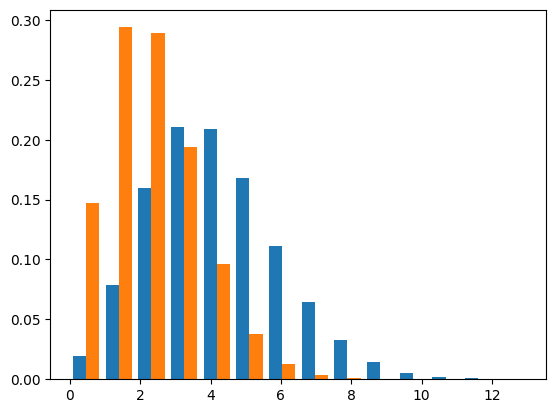

In [7]:
nEvents = 100000

bj=getbJetData(nEvents, fracDecay=0.2) #only train uses this
lf=getLFJetData(nEvents)

length_b = []
for i in bj:
    length_b.append(len(i))
length_lf = []
for i in lf:
    length_lf.append(len(i))
# this is for poisson likelihood
print(max(length_lf))
lenCount, lenBins, lenPatch=plt.hist([length_b,length_lf],bins=np.linspace(0,13,15), density=True)

In [8]:
bjFlat = flatten(bj)

lfFlat = flatten(lf)

print(f"{len(bjFlat)} vs {len(lfFlat)}")

400420 vs 199072


[[0.00897205 0.00942066 0.01121507 0.00919635 0.00919635 0.00852345
  0.00942066 0.01256087 0.00807485 0.00964496 0.00852345 0.00785055
  0.01121507 0.00762624 0.00807485 0.00919635 0.00986926 0.00964496
  0.00829915 0.00919635 0.00964496 0.01121507 0.01166367 0.00807485
  0.00762624 0.00964496 0.00874775 0.00829915 0.01054216 0.00717764
  0.00874775 0.00874775 0.00964496 0.00717764 0.00919635 0.00695334
  0.00852345 0.00897205 0.00807485 0.01076646 0.01121507 0.00986926
  0.00942066 0.00807485 0.00583183 0.01009356 0.01031786 0.00807485
  0.00807485 0.00986926 0.00762624 0.00807485 0.00964496 0.00874775
  0.01009356 0.00986926 0.00583183 0.00717764 0.00919635 0.00942066
  0.01054216 0.00807485 0.00986926 0.00897205 0.00583183 0.00785055
  0.00829915 0.00605614 0.00942066 0.01099076 0.00807485 0.00605614
  0.00852345 0.01076646 0.00717764 0.00919635 0.01031786 0.01031786
  0.00852345 0.01121507 0.00762624 0.01054216 0.00852345 0.01031786
  0.00986926 0.00785055 0.00807485 0.00807485 0.

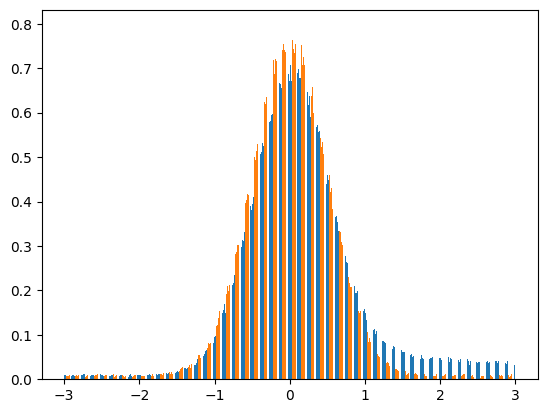

In [9]:
bins = np.linspace(-3,3,500)
#c1, b1, p1 = plt.hist(bjFlat,bins=bins,density=True)
#c2, b2, p2 = plt.hist(lfFlat,bins=bins,histtype="step", density=True)
TrainHistCounts, TrainHistBins, patch = plt.hist([bjFlat,lfFlat],bins=bins,density=True)
#plt.yscale("log")
print(TrainHistCounts)
plt.show()

plot ROC

In [34]:
def pltROCnAUC(counts, bins, label): 
    x=[]
    y=[]
    for i in range(len(counts[0])):
        p = 0
        n = 0
        for j in range(i,len(counts[0])):
            p = p + counts[0][j]*(bins[j+1]-bins[j])
            n = n + counts[1][j]*(bins[j+1]-bins[j])
        x.append(p)
        y.append(n)
    AUC=trapz(x,y)
    print(x)
    print(y)
    plt.plot(y,x,label=label)
    plt.legend()
    return AUC

In [11]:
#getting data
n=1000
train = getData(n)
bj_test=getbJetData(n,fracDecay=0.2)
lf_test=getLFJetData(n)

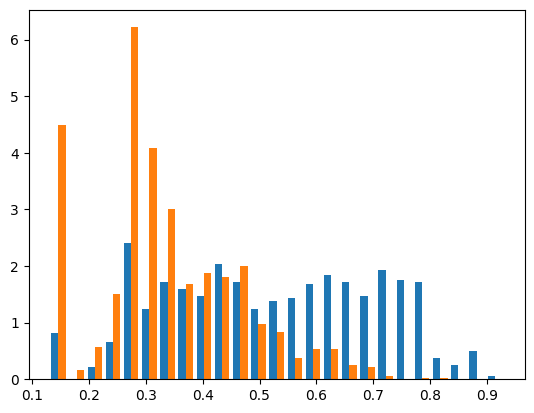

In [12]:
#KNN
train1=copy.deepcopy(train)
DataSameLen(train1)
bj_test1 = copy.deepcopy(bj_test)
DataSameLen(bj_test1)
lf_test1 = copy.deepcopy(lf_test)
DataSameLen(lf_test1)

if (len(bj_test1[0])<len(train1[0])-1):
    for i in bj_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)
if (len(lf_test1[0])<len(train1[0])-1):
    for i in lf_test1:
        while(len(i)<len(train1[0])-1):
            i.append(0)

b_prob=[]
lf_prob=[]
for i in bj_test1:
    b_prob.append(BjetProb(train1,i,100))
for i in lf_test1:
    lf_prob.append(BjetProb(train1,i,100))
counts, bins, patches= plt.hist([b_prob,lf_prob], bins=25, density=True)

In [13]:
def trim(floatListList, N):
    res=[]
    falseNum=0
    for i in floatListList:
        if len(i)<N:
            floatListList.remove(i)
            falseNum=falseNum+1
        else:
            mx=[]
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res, falseNum  

def trimTrain(floatListList, N):
    res=[]
    for i in floatListList:
        ind = i[0]
        i.pop(0)
        if len(i)<N:
            floatListList.remove(i)
        else:
            mx=[]
            mx.append(ind)
            for j in range(N):
                mx.append(np.max(i))
                i.remove(np.max(i))
            res.append(mx)
    return res       

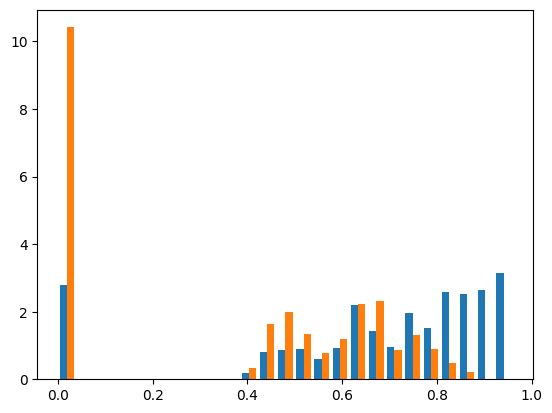

In [14]:
#2d-KNN
train2=copy.deepcopy(train)
train2=trimTrain(train2,2)

bj_test2=copy.deepcopy(bj_test)
lf_test2=copy.deepcopy(lf_test)
bj_test2, bj_fn = trim(bj_test2,2)
lf_test2, lf_fn = trim(lf_test2,2)

b_prob2=[]
lf_prob2=[]
for i in bj_test2:
    b_prob2.append(BjetProb(train2,i,100))
for i in range(bj_fn):
    b_prob2.append(0)
for i in lf_test2:
    lf_prob2.append(BjetProb(train2,i,100))
for i in range(lf_fn):
    lf_prob2.append(0)
counts2, bins2, patches2 = plt.hist([b_prob2,lf_prob2], bins=25, density=True)

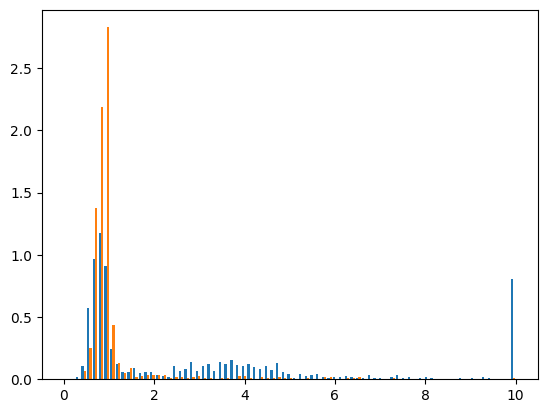

In [15]:
#likelyhood #This uses the histogram for d0
def probInHist(d0, counts, bins): #counts is list of lists
    x=len(bins)-2
    for i in range(len(bins)): 
        if d0 < bins[i]:
            x=i-1
            break
    p=(counts[0][x])/(counts[1][x])
    return p

def likelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi) 
    return p

def llhANDjets(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append([pi,i]) ###############just to see the jets and its likelihood
    return p

bj_test3=copy.deepcopy(bj_test)
lf_test3=copy.deepcopy(lf_test)

bj_p3=likelihood(bj_test3,TrainHistCounts,TrainHistBins)
lf_p3=likelihood(lf_test3,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p3)):
    if bj_p3[i] > 10:
        bj_p3[i] = 10

for i in range(len(lf_p3)):
    if lf_p3[i] > 10:
        lf_p3[i] = 10

bj_p3_ = llhANDjets(copy.deepcopy(bj_test3),TrainHistCounts,TrainHistBins)
lf_p3_ =llhANDjets(copy.deepcopy(lf_test3),TrainHistCounts,TrainHistBins)

bj_p3_.sort(key = lambda ls : ls[0])
lf_p3_.sort(key = lambda ls : ls[0])

counts3, bins3, patches3 = plt.hist([bj_p3,lf_p3], bins=np.linspace(0,10,80), density=True)

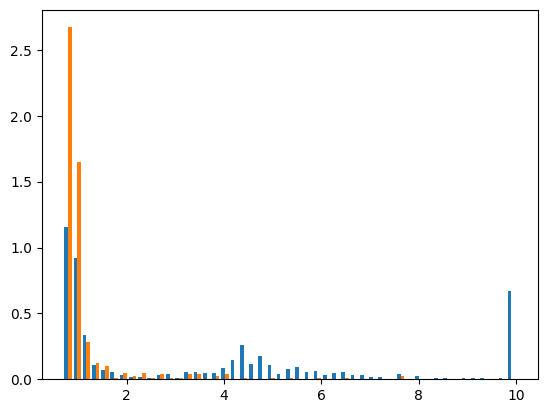

In [16]:
# 2d likelihoood
bj_test5=copy.deepcopy(bj_test2)
lf_test5=copy.deepcopy(lf_test2)

bj_p5=likelihood(bj_test5,TrainHistCounts,TrainHistBins)
lf_p5=likelihood(lf_test5,TrainHistCounts,TrainHistBins)

for i in range(bj_fn):
    bj_p5.append(min(bj_p5))
for i in range(bj_fn):
    lf_p5.append(min(lf_p5))

for i in range(len(bj_p5)):
    if bj_p5[i] > 10:
        bj_p5[i] = 10

for i in range(len(lf_p5)):
    if lf_p5[i] > 10:
        lf_p5[i] = 10

counts5, bins5, patches5 = plt.hist([bj_p5,lf_p5], bins=np.linspace(0.7,10,50), density=True)

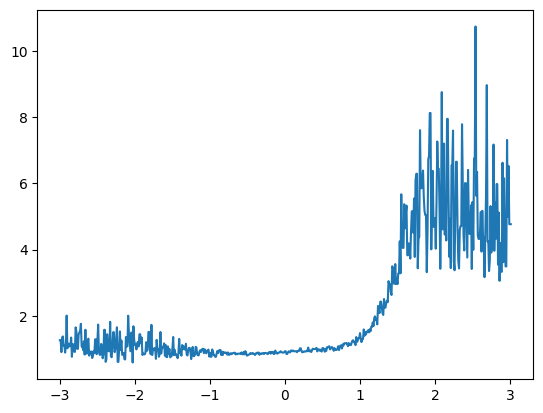

In [17]:
j=-3
list=[]
list.append(j)
while j<=3:
    j+=0.01
    list.append(j)

list2=[]
for d0 in list:
    k=probInHist(d0,TrainHistCounts,TrainHistBins)
    list2.append(k)

plt.plot(list,list2)

/var/folders/vg/yfv452x11j97tr10qw3gk5440000gn/T/ipykernel_79691/1708564958.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  p=(counts[0][x])/(counts[1][x])


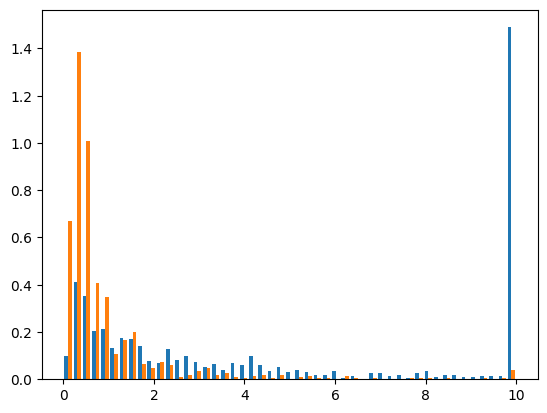

In [18]:
#POISSSON likelyhood
def Poissonlikelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=probInHist(len(i),lenCount,lenBins)
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi)
    return p

bj_test4=copy.deepcopy(bj_test) 
lf_test4=copy.deepcopy(lf_test)

bj_p4=Poissonlikelihood(bj_test4,TrainHistCounts,TrainHistBins)
lf_p4=Poissonlikelihood(lf_test4,TrainHistCounts,TrainHistBins)

for i in range(len(bj_p4)):
    if bj_p4[i] > 10:
        bj_p4[i] = 10

for i in range(len(lf_p4)):
    if lf_p4[i] > 10:
        lf_p4[i] = 10
        
counts4, bins4, patches4 = plt.hist([bj_p4,lf_p4], bins=np.linspace(0,10,50), density=True)


AUC of knn: 0.7885210000000005
AUC of 2d knn: 0.7913644495039842
AUC of likelihood: 0.6583555000000002
AUC of poisson likelihood: 0.8241745000000005
AUC of 2d likelihood: 0.7569786679808508


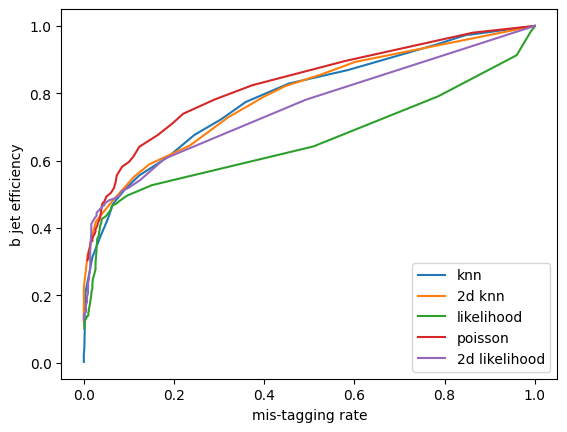

In [19]:
area1 = pltROCnAUC(counts, bins, "knn")
area2 = pltROCnAUC(counts2, bins2, "2d knn")
area3 = pltROCnAUC(counts3, bins3, "likelihood")
area4 = pltROCnAUC(counts4, bins4, "poisson")
area5 = pltROCnAUC(counts5, bins5, "2d likelihood")

plt.ylabel("b jet efficiency")
plt.xlabel("mis-tagging rate")
print("AUC of knn:",-area1)
print("AUC of 2d knn:",-area2)
print("AUC of likelihood:",-area3)
print("AUC of poisson likelihood:",-area4)
print("AUC of 2d likelihood:",-area5)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [39]:
trainingData = DataSameLen(copy.deepcopy(train))
Ndimentions=len(trainingData[0])
for i in trainingData:
    if i[0]==True:
        i[0]=1
    else:
        i[0]=0
trainingData = np.array(trainingData)
X = trainingData[:,1:Ndimentions]
y = trainingData[:,0]
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

NNmodel = nn.Sequential(
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,Ndimentions-1),
   nn.ReLU(),
   nn.Linear(Ndimentions-1,1),
   nn.Sigmoid()
)

In [40]:
loss_fn = nn.BCELoss()
optimizer=optim.Adam(NNmodel.parameters(),lr = 0.001)

In [41]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = NNmodel(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.7107739448547363
Finished epoch 1, latest loss 0.6558712124824524
Finished epoch 2, latest loss 0.684095561504364
Finished epoch 3, latest loss 0.6031206250190735
Finished epoch 4, latest loss 0.6031531095504761
Finished epoch 5, latest loss 0.606496274471283
Finished epoch 6, latest loss 0.5778275728225708
Finished epoch 7, latest loss 0.5908564925193787
Finished epoch 8, latest loss 0.5889872312545776
Finished epoch 9, latest loss 0.5830096006393433
Finished epoch 10, latest loss 0.5750383734703064
Finished epoch 11, latest loss 0.5636336207389832
Finished epoch 12, latest loss 0.5515745282173157
Finished epoch 13, latest loss 0.5393835306167603
Finished epoch 14, latest loss 0.5272480249404907
Finished epoch 15, latest loss 0.5150787830352783
Finished epoch 16, latest loss 0.5032843351364136
Finished epoch 17, latest loss 0.49378785490989685
Finished epoch 18, latest loss 0.4838889539241791
Finished epoch 19, latest loss 0.10194729268550873
Finished e

Accuracy 0.7540000081062317


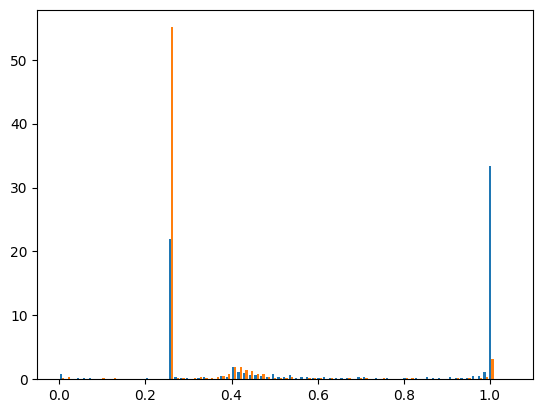

In [68]:
def padding(trainLength, testdata):
    while len(testdata[0])<trainLength:
        for i in testdata:
            i.append(0)
    while len(testdata[0])>trainLength:
        for i in testdata:
            i.remove(min(i))
bj_test6 = DataSameLen(copy.deepcopy(bj_test))
lf_test6 = DataSameLen(copy.deepcopy(lf_test))
padding(len(X[0]),bj_test6)
padding(len(X[0]),lf_test6)

with torch.no_grad():
    y_pred = NNmodel(X)
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

bj_test6 = torch.tensor(bj_test6, dtype=torch.float32)
lf_test6 = torch.tensor(lf_test6, dtype=torch.float32)

with torch.no_grad():
    bj_prob6 = NNmodel(bj_test6)
    lf_prob6 = NNmodel(lf_test6)

counts6, bins6, _ = plt.hist([torch.flatten(bj_prob6),torch.flatten(lf_prob6)],bins=np.linspace(0,1.05,80),density=True)

[1.0, 0.9890000000000001, 0.9880000000000001, 0.9880000000000001, 0.9860000000000001, 0.9840000000000001, 0.9820000000000001, 0.9810000000000001, 0.9810000000000001, 0.9800000000000001, 0.9800000000000001, 0.9790000000000001, 0.9790000000000001, 0.9790000000000001, 0.9780000000000001, 0.9780000000000001, 0.9760000000000001, 0.9760000000000001, 0.9760000000000001, 0.9750000000000001, 0.683, 0.679, 0.677, 0.674, 0.674, 0.671, 0.666, 0.665, 0.665, 0.658, 0.653, 0.628, 0.613, 0.6000000000000001, 0.5920000000000001, 0.5840000000000001, 0.5780000000000001, 0.573, 0.5609999999999999, 0.5569999999999999, 0.5529999999999999, 0.544, 0.542, 0.537, 0.533, 0.53, 0.528, 0.524, 0.5209999999999999, 0.5189999999999999, 0.516, 0.514, 0.5129999999999999, 0.5089999999999999, 0.504, 0.504, 0.502, 0.5009999999999999, 0.49899999999999994, 0.49899999999999994, 0.49899999999999994, 0.49599999999999994, 0.49499999999999994, 0.49299999999999994, 0.49199999999999994, 0.48799999999999993, 0.48599999999999993, 0.48

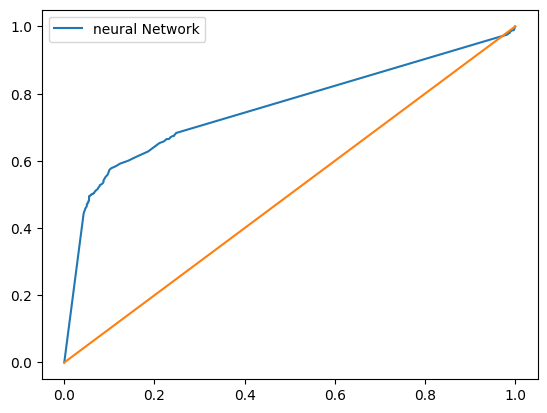

In [70]:
area6 = pltROCnAUC(counts6, bins6, "neural Network")
print("AUC of neural network:",-area6)
x=[0.0,0.2,0.4,0.6,0.8,1.0]
plt.plot(x,x)